In [1]:
%run SAT_help_functions.ipynb
%matplotlib inline

In [3]:
## save dataframe for each frequency levels
#data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/SpeedAccData.csv"
#save_dir = '/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq'
#df = pd.read_csv(data_dir)
#Frequencies = [1,  2, 3,  4,  5,  6]
#participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

#for freq in Frequencies:
#    data_freq = df[df.loc[:,'Frequency']==freq]
#    for sub in range(sample_size):
#        data_freq_sub = data_freq[data_freq.loc[:,'Participant']==participants[sub]]
#        data_freq_sub.to_csv(save_dir+str(freq)+'/sub'+str(sub+1)+'.csv')
    

In [4]:
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"
sample_size = 16
correct = 'Correct'
corrects = [1, 0]
cond = 'SAT' 
conds = [1, 2]
rt = 'RT'

participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

model = 'DDM2v2a2ter'
dataset = 'Wagenmakers2008'
params_all = pd.read_csv(model+"result"+dataset+".csv")# .drop(labels=3, axis=0)

In [5]:
def get_RT_quantile_sub(df, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):
    
    # RT quantiles
    df_cor = df.loc[df[correct]==corrects[0]]
    RT_cor_s = df_cor.loc[df_cor[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_cor_a = df_cor.loc[df_cor[cond]==conds[1]][rt].quantile(q=quantiles)

    df_err = df.loc[df[correct]==corrects[1]]
    RT_err_s = df_err.loc[df_err[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_err_a = df_err.loc[df_err[cond]==conds[1]][rt].quantile(q=quantiles)
    
    # number of trials
    num_cor_s = len(df_cor.loc[df_cor[cond]==conds[0]])
    num_cor_a = len(df_cor.loc[df_cor[cond]==conds[1]])

    num_err_s = len(df_err.loc[df_err[cond]==conds[0]])
    num_err_a = len(df_err.loc[df_err[cond]==conds[1]])
    #print(df.loc[:,"Participant"])
    #print(RT_cor_s)
    #print(RT_cor_a)
    return RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, [num_cor_s,num_cor_a,num_err_s,num_err_a]



In [6]:
#get_RT_quantile_sub(df = df, rt = rt, correct = correct, corrects = corrects, cond = cond, conds = conds)

In [7]:
def get_RT_quantile(data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss.mean(axis = 0), RT_cor_as.mean(axis = 0), RT_err_ss.mean(axis = 0), RT_err_as.mean(axis = 0), nums.mean(axis = 0)


In [8]:
#data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq1/sub"

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

In [9]:
#params = np.array(params_all)[0,1:6]

class DriftBothSpeedAcc(Drift):
    name = "DriftBothSpeedAcc"
    required_parameters = ["Vspeed","Vacc", "Kspeed", "Kacc"]
    required_conditions = ['Cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.Vspeed + x*self.Kspeed 
        elif conditions['Cond'] == 'Accuracy':
            return self.Vacc + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")
            
class DriftConstantSpeedAcc(Drift):
    name = "DriftConstantSpeedAcc"
    required_parameters = ["Vspeed","Vacc"]
    required_conditions = ['Cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.Vspeed
        elif conditions['Cond'] == 'Accuracy':
            return self.Vacc
        else: 
            print("Non-implemented SAT conditions")

class DriftExcitationSpeedAcc(Drift):
    name = "DriftSpeedAcc"
    required_parameters = ["drift", "Kspeed", "Kacc"]
    required_conditions = ['Cond']
        
    def get_drift(self, x, t, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.drift + x*self.Kspeed 
        elif conditions['Cond'] == 'Accuracy':
            return self.drift + x*self.Kacc
        else: 
            print("Non-implemented SAT conditions")

class BoundSpeedAcc(Bound):
    name = "BoundSpeedAcc"
    required_parameters = ["Bspeed", "Bacc"]
    required_conditions = ['Cond']
    def get_bound(self, conditions, *args, **kwargs):
        assert self.Bacc > 0
        assert self.Bspeed > 0
        if conditions['Cond'] == 'Speed':
            return self.Bspeed
        elif conditions['Cond'] == 'Accuracy':
            return self.Bacc
        else:
            print("Non-implemented SAT conditions")
            
class NondecisionSpeedAcc(OverlayNonDecision):
    name = "NondecisionSpeedAcc"
    required_parameters = ["tSpeed", 'tAcc']
    required_conditions = ['Cond']
        
    def get_nondecision_time(self, conditions, **kwargs):
        if conditions['Cond'] == 'Speed':
            return self.tSpeed 
        elif conditions['Cond'] == 'Accuracy':
            return self.tAcc
        else: 
            print("Non-implemented SAT conditions")

def get_RT_quantile_DDM_sub_speed(params, T_dur=3):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    return get_RT_quantile_sub(data_s, 'correct', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_DDM_sub(params = np.array(params_all)[3,1:6])

def get_RT_quantile_DDM_sub_accuracy(params, T_dur=3):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    return get_RT_quantile_sub(data_a, 'correct', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')

In [10]:
#np.array(params_all)[3,1:6]

In [11]:
def get_RT_quantile_DDM(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        params = np.array(params_all)[i,1:7]
        
        
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub_speed(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

In [12]:
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all[params_all.loc[:,'Frequency']==1],
                                                                   sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

/Users/wangjiashun/opt/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [13]:
Frequencies = [1,  2, 3,  4,  5,  6]


/Users/wangjiashun/opt/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


FloatingPointError: invalid value encountered in double_scalars

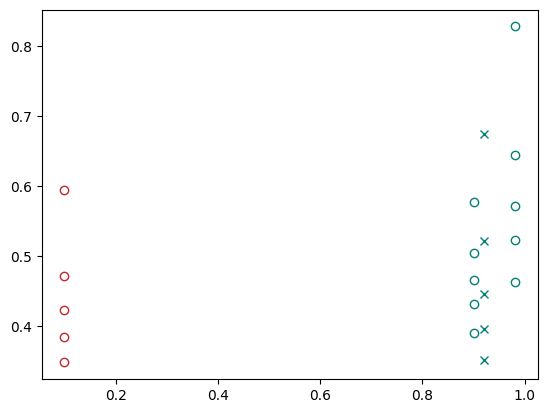

In [14]:
def DDM_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    
    for freq in Frequencies:
        data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    
        
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')

        ## data generated from model
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(params_all = params_all[params_all.loc[:,'Frequency']==freq]
                                                                           ,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')

    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
DDM_QP_plot()

In [91]:
model = 'OUM2v2k2ter'
dataset = 'Wagenmakers2008'
params_all = pd.read_csv(model+"result"+dataset+".csv")#.drop(labels=3, axis=0)


In [92]:

            
def get_RT_quantile_OUM2v2k2ter_sub(params, T_dur=3):

    Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'correct', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

In [93]:
def get_RT_quantile_OUM2v2k2ter(params_all, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):

        params = np.array(params_all)[i,1:8]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
        cond = cond, conds = conds, rt = rt)

<AxesSubplot:xlabel='Probability of Response', ylabel='RT'>

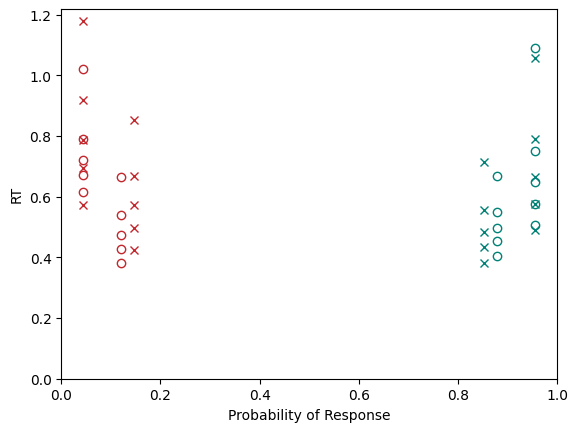

In [101]:
def OUM2v2k2ter_QP_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    
    for freq in [6]:
        data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Lexical Decision Data/dataByFreq/Freq"+str(freq)+"/sub"    

        ## behavioral data
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(data_dir = data_dir,sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = '#c1272d', fillstyle = 'none')

        ## data generated from model
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all[params_all.loc[:,'Frequency']==freq],
                                                                                   sample_size= sample_size, 
                                                                       correct = correct, corrects = corrects,
                                                                       cond = cond, conds = conds, rt = rt)

        ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#008176', fillstyle = 'none')
        ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#c1272d', fillstyle = 'none')
        ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#c1272d', fillstyle = 'none')

    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)
OUM2v2k2ter_QP_plot()